In [1]:
import sys
import importlib
import os
from optparse import OptionParser
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import random
import scanpy as sc

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable as var

import tifffile as tf

from tqdm import tqdm

import random as rd

import pickle

# from baonet import CreateDataset

#from My_eval import eval_net
#from My_test import test_net
#from Train_phase2GT import UNet_3
#from data_load_expand import *
#from npcc_loss import *

sys.path.append("../") # go to parent dir
# importlib.reload(sys.modules['baonet_modules'])
from baonet_modules import *

In [2]:
sc.set_figure_params()

In [3]:
data_path = '/home/kkobayas/koseki-data/Raman/data/unet/fovs_bin4_mip_merged/'
save_path = './results'

genes = ['Nanog', 'Col1a1', 'Utf1', 'Krt7', 'Peg10', 'Bgn', 'Nnat', 'Fabp7', 'Epcam']

random.seed(2021)

# input channel (bf)
input_c = 'bf'
n_channels = 11
# input_c = 0
# # gt channel (nanog)
# gt_c = 1
gt_c = 'mip'
o_channels = 9 

kernel=(5,5)
padding=(2,2)

# kernel=(3,3)
# padding=(1,1)

pix = 50
n_img = 100

n_epochs = 100

# loss function. 'npcc' or mse' or 'mae'
loss = 'mae'
# mse = True

val_percent = 0.1
gpu=True

In [4]:
net = UNet_3(n_channels=n_channels, n_classes=o_channels)
net.cuda()
net = torch.nn.DataParallel(net)

In [5]:
'''data loading'''
def CreateDataset(data_path, test_percent, input_c, gt_c):
    Train_dataset = []
    
    paths_list = os.listdir(os.path.join(data_path, input_c))
    gt_paths_list = os.listdir(os.path.join(data_path, gt_c))
    
    if '.ipynb_checkpoints' in paths_list:
        paths_list.remove('.ipynb_checkpoints')
    
    if '.ipynb_checkpoints' in gt_paths_list:
        gt_paths_list.remove('.ipynb_checkpoints')
    
    print(len(paths_list))
    print(len(gt_paths_list))
    train_len = int(len(paths_list)*(1-test_percent))
    test_len = len(paths_list)-train_len
    Train_idxes = range(0,train_len)
    Test_idxes = range(train_len, len(paths_list))
  
    for idx in tqdm(Train_idxes):
        inputpath = os.path.join(data_path, input_c, paths_list[idx])
        gtpath = os.path.join(data_path, gt_c, gt_paths_list[idx])
        if (os.path.exists(inputpath) == False):
            return -1
        else:
            if (paths_list[idx].find('.tiff') == -1) or (gt_paths_list[idx].find('.tiff') == -1):
                continue
            img = tf.imread(inputpath)
            if np.any(np.isnan(img)):
                continue
            gt = tf.imread(gtpath)
            
#             print(gtpath)
#             print(img.shape)
            # sample random regions, upsample 4x
            
            w = img.shape[1]
            for i in range(n_img):
                r_idx = rd.randint(0,w-pix)
                r_idy = rd.randint(0,w-pix)
                img_cr = img[:,r_idx:r_idx+pix,r_idy:r_idy+pix]
                gt_cr = gt[:,r_idx:r_idx+pix,r_idy:r_idy+pix]
                
                Train_dataset.append([img_cr,gt_cr])
                
                if gt_cr.shape[0]>1:
                    # flip
                    Train_dataset.append([np.flip(img_cr,1),np.flip(gt_cr,1)])
                    Train_dataset.append([np.flip(img_cr,2),np.flip(gt_cr,2)])
                    
                    # rotate
                    Train_dataset.append([np.rot90(img_cr, axes=(1,2)),np.rot90(gt_cr, axes=(1,2))])
                    Train_dataset.append([np.rot90(img_cr, axes=(2,1)),np.rot90(gt_cr, axes=(2,1))])
                else:
                    # flip
                    Train_dataset.append([np.flip(img_cr,1),np.flip(gt_cr,0)])
                    Train_dataset.append([np.flip(img_cr,2),np.flip(gt_cr,1)])

                    # rotate
                    Train_dataset.append([np.rot90(img_cr, axes=(1,2)),np.rot90(gt_cr, axes=(0,1))])
                    Train_dataset.append([np.rot90(img_cr, axes=(2,1)),np.rot90(gt_cr, axes=(1,0))])
                
#             Train_dataset.append([img,gt])
    Test_dataset = []
    for ii in tqdm(Test_idxes):
#         print(paths_list[ii])
        inputpath = os.path.join(data_path, input_c, paths_list[ii])
        gtpath = os.path.join(data_path, gt_c, gt_paths_list[ii])
        if (os.path.exists(inputpath) == False):# or (os.path.exists(gtpath)) is False:
            return -1
        else:
            if (paths_list[idx].find('.tiff') == -1) or (gt_paths_list[idx].find('.tiff') == -1):
                continue
            img1 = tf.imread(inputpath)
            if np.any(np.isnan(img1)):
                continue
            gt1 = tf.imread(gtpath)
            
            # sample random regions, upsample 4x
            w = img1.shape[1]
            for i in range(n_img):
                r_idx = rd.randint(0,w-pix)
                r_idy = rd.randint(0,w-pix)
                img1_cr = img1[:,r_idx:r_idx+pix,r_idy:r_idy+pix]
                gt1_cr = gt1[:,r_idx:r_idx+pix,r_idy:r_idy+pix]
                
                Test_dataset.append([img1_cr,gt1_cr])
                
                if gt_cr.shape[0]>1:
                   # flip
                    Test_dataset.append([np.flip(img1_cr,1),np.flip(gt1_cr,1)])
                    Test_dataset.append([np.flip(img1_cr,2),np.flip(gt1_cr,2)])

                    # rotate
                    Test_dataset.append([np.rot90(img1_cr, axes=(1,2)),np.rot90(gt1_cr, axes=(1,2))])
                    Test_dataset.append([np.rot90(img1_cr, axes=(2,1)),np.rot90(gt1_cr, axes=(2,1))]) 
                else:
                    # flip
                    Test_dataset.append([np.flip(img1_cr,1),np.flip(gt1_cr,0)])
                    Test_dataset.append([np.flip(img1_cr,2),np.flip(gt1_cr,1)])

                    # rotate
                    Test_dataset.append([np.rot90(img1_cr, axes=(1,2)),np.rot90(gt1_cr, axes=(0,1))])
                    Test_dataset.append([np.rot90(img1_cr, axes=(2,1)),np.rot90(gt1_cr, axes=(1,0))])
                
#             Test_dataset.append([img1,gt1])
    return Train_dataset, Test_dataset

In [6]:
test_percent=0.1
[Train_dataset, Test_dataset] = CreateDataset(data_path, test_percent, input_c, gt_c)

280
280


100%|██████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 17.32it/s]


In [ ]:
# [train_loss,val_loss] = train_net(net=net, epochs = 500, batch_size = 400, lr = 0.01, val_percent = 0.1, save_cp=True, gpu=True, Train_dataset=Train_dataset, Test_dataset=Test_dataset, loss=loss, save_path=save_path)
[train_loss,val_loss] = train_net(net=net, epochs = n_epochs, batch_size = 400, lr = 0.02, val_percent = 0.1, save_cp=True, gpu=True, Train_dataset=Train_dataset, Test_dataset=Test_dataset, loss=loss, save_path=save_path)


        Starting training:
        Epochs: 100
        Batch size: 400
        Learning rate: 0.02
        Training size: 113400
        Validation size: 12600
        Checkpoints: True
        CUDA: True
    
Starting epoch 1/100.
0.0000 --- loss: 495.100647
0.0035 --- loss: 449.901123
0.0071 --- loss: 974.333862
0.0106 --- loss: 450.840332
0.0141 --- loss: 520.870605
0.0176 --- loss: 488.223938
0.0212 --- loss: 429.879547
0.0247 --- loss: 470.315338
0.0282 --- loss: 531.322998
0.0317 --- loss: 544.110962
0.0353 --- loss: 527.915100
0.0388 --- loss: 579.878296
0.0423 --- loss: 394.631683
0.0459 --- loss: 482.036530
0.0494 --- loss: 383.768860
0.0529 --- loss: 405.385559
0.0564 --- loss: 376.408630
0.0600 --- loss: 420.694336
0.0635 --- loss: 385.555695
0.0670 --- loss: 397.718170
0.0705 --- loss: 335.833252
0.0741 --- loss: 307.161896
0.0776 --- loss: 318.528076
0.0811 --- loss: 319.997437
0.0847 --- loss: 330.796112
0.0882 --- loss: 300.491547
0.0917 --- loss: 328.393524
0.0952 --- 

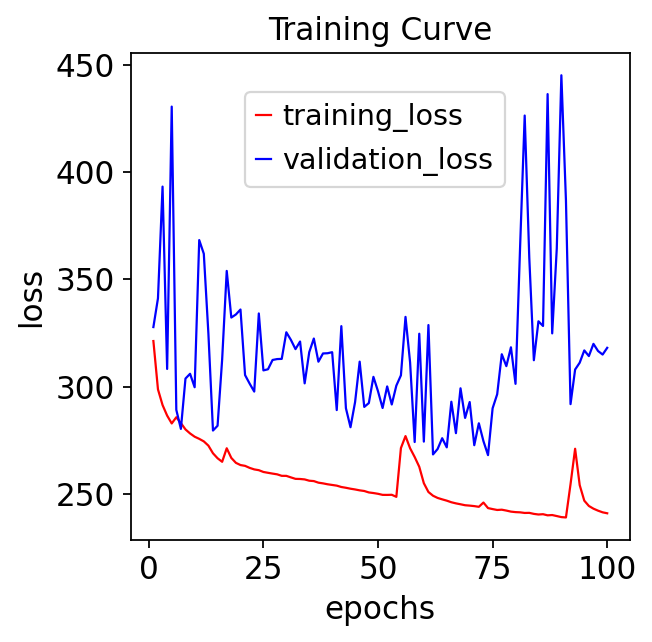

In [75]:
x = np.arange(1,n_epochs+1)

y1 = np.array(train_loss)
y2 = np.array(val_loss)

plt.plot(x, y1, color="r", linestyle="-", linewidth=1, label="training_loss")
plt.plot(x, y2, color="b", linestyle="-", linewidth=1, label="validation_loss")

plt.xlabel("epochs")
plt.ylabel("loss")

plt.legend(loc='upper left', bbox_to_anchor=(0.2, 0.95))

plt.title("Training Curve")

plt.savefig('Training curve.png')
plt.grid(None)
plt.show()

## Evaluate prediction vs ground truth

In [ ]:
'''load a network at an epoch'''
iddataset = split_train_val(Train_dataset, val_percent) # shuffle the data
train = iddataset['train']
val = iddataset['val']

epochs = np.arange(0,n_epochs-10+1,10)
for epoch in epochs:
    path_net = 'results/net_'+str(epoch)+'.pth'

    net = torch.load(path_net)

    fp = 'results/epoch_'+str(epoch)

    if not os.path.isdir(fp):
        os.mkdir(fp)

    predict_from_net(net, train, val, Test_dataset, fp, True)

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
sets = ['train', 'val', 'test']
corrs = {}
cosines = {}

genes = ['Nanog', 'Col1a1', 'Utf1', 'Krt7', 'Peg10', 'Bgn', 'Nnat', 'Fabp7', 'Epcam']

for s in sets:
    corrs[s] = {}
    cosines[s] = {}
    for i,g in enumerate(genes):
        corrs[s][g] = list()
        cosines[s][g] = list()
        for epoch in epochs:
            root = os.path.join(save_path, 'epoch_'+str(epoch), s)

            dirlist = os.listdir(root) # dir is your directory path
            last_frame = int(len(dirlist)/3)-1

            gt_means = list()
            pred_means = list()
            for j in range(last_frame):
                gt = pickle.load(open(root+'/GT_'+str(j+1)+'.pkl', 'rb' ))
                pred = pickle.load(open(root+'/Prediction_'+str(j+1)+'.pkl', 'rb' ))
                gt_means.append(np.mean(gt[0,i,:,:]))
                pred_means.append(np.mean(pred[0,i,:,:]))

                #         from scipy.stats import pearsonr
                #         plt.scatter(gt_means, pred_means)
                #         plt.grid(None)
            corrs[s][g].append(pearsonr(gt_means, pred_means)[0])
            cosines[s][g].append(cosine_similarity([gt_means], [pred_means])[0,0])


In [61]:
import pickle as pkl
with open('corrs.pkl', "wb") as output:
    pkl.dump(corrs,output)

In [62]:
with open('cosines.pkl', "wb") as output:
    pkl.dump(cosines,output)

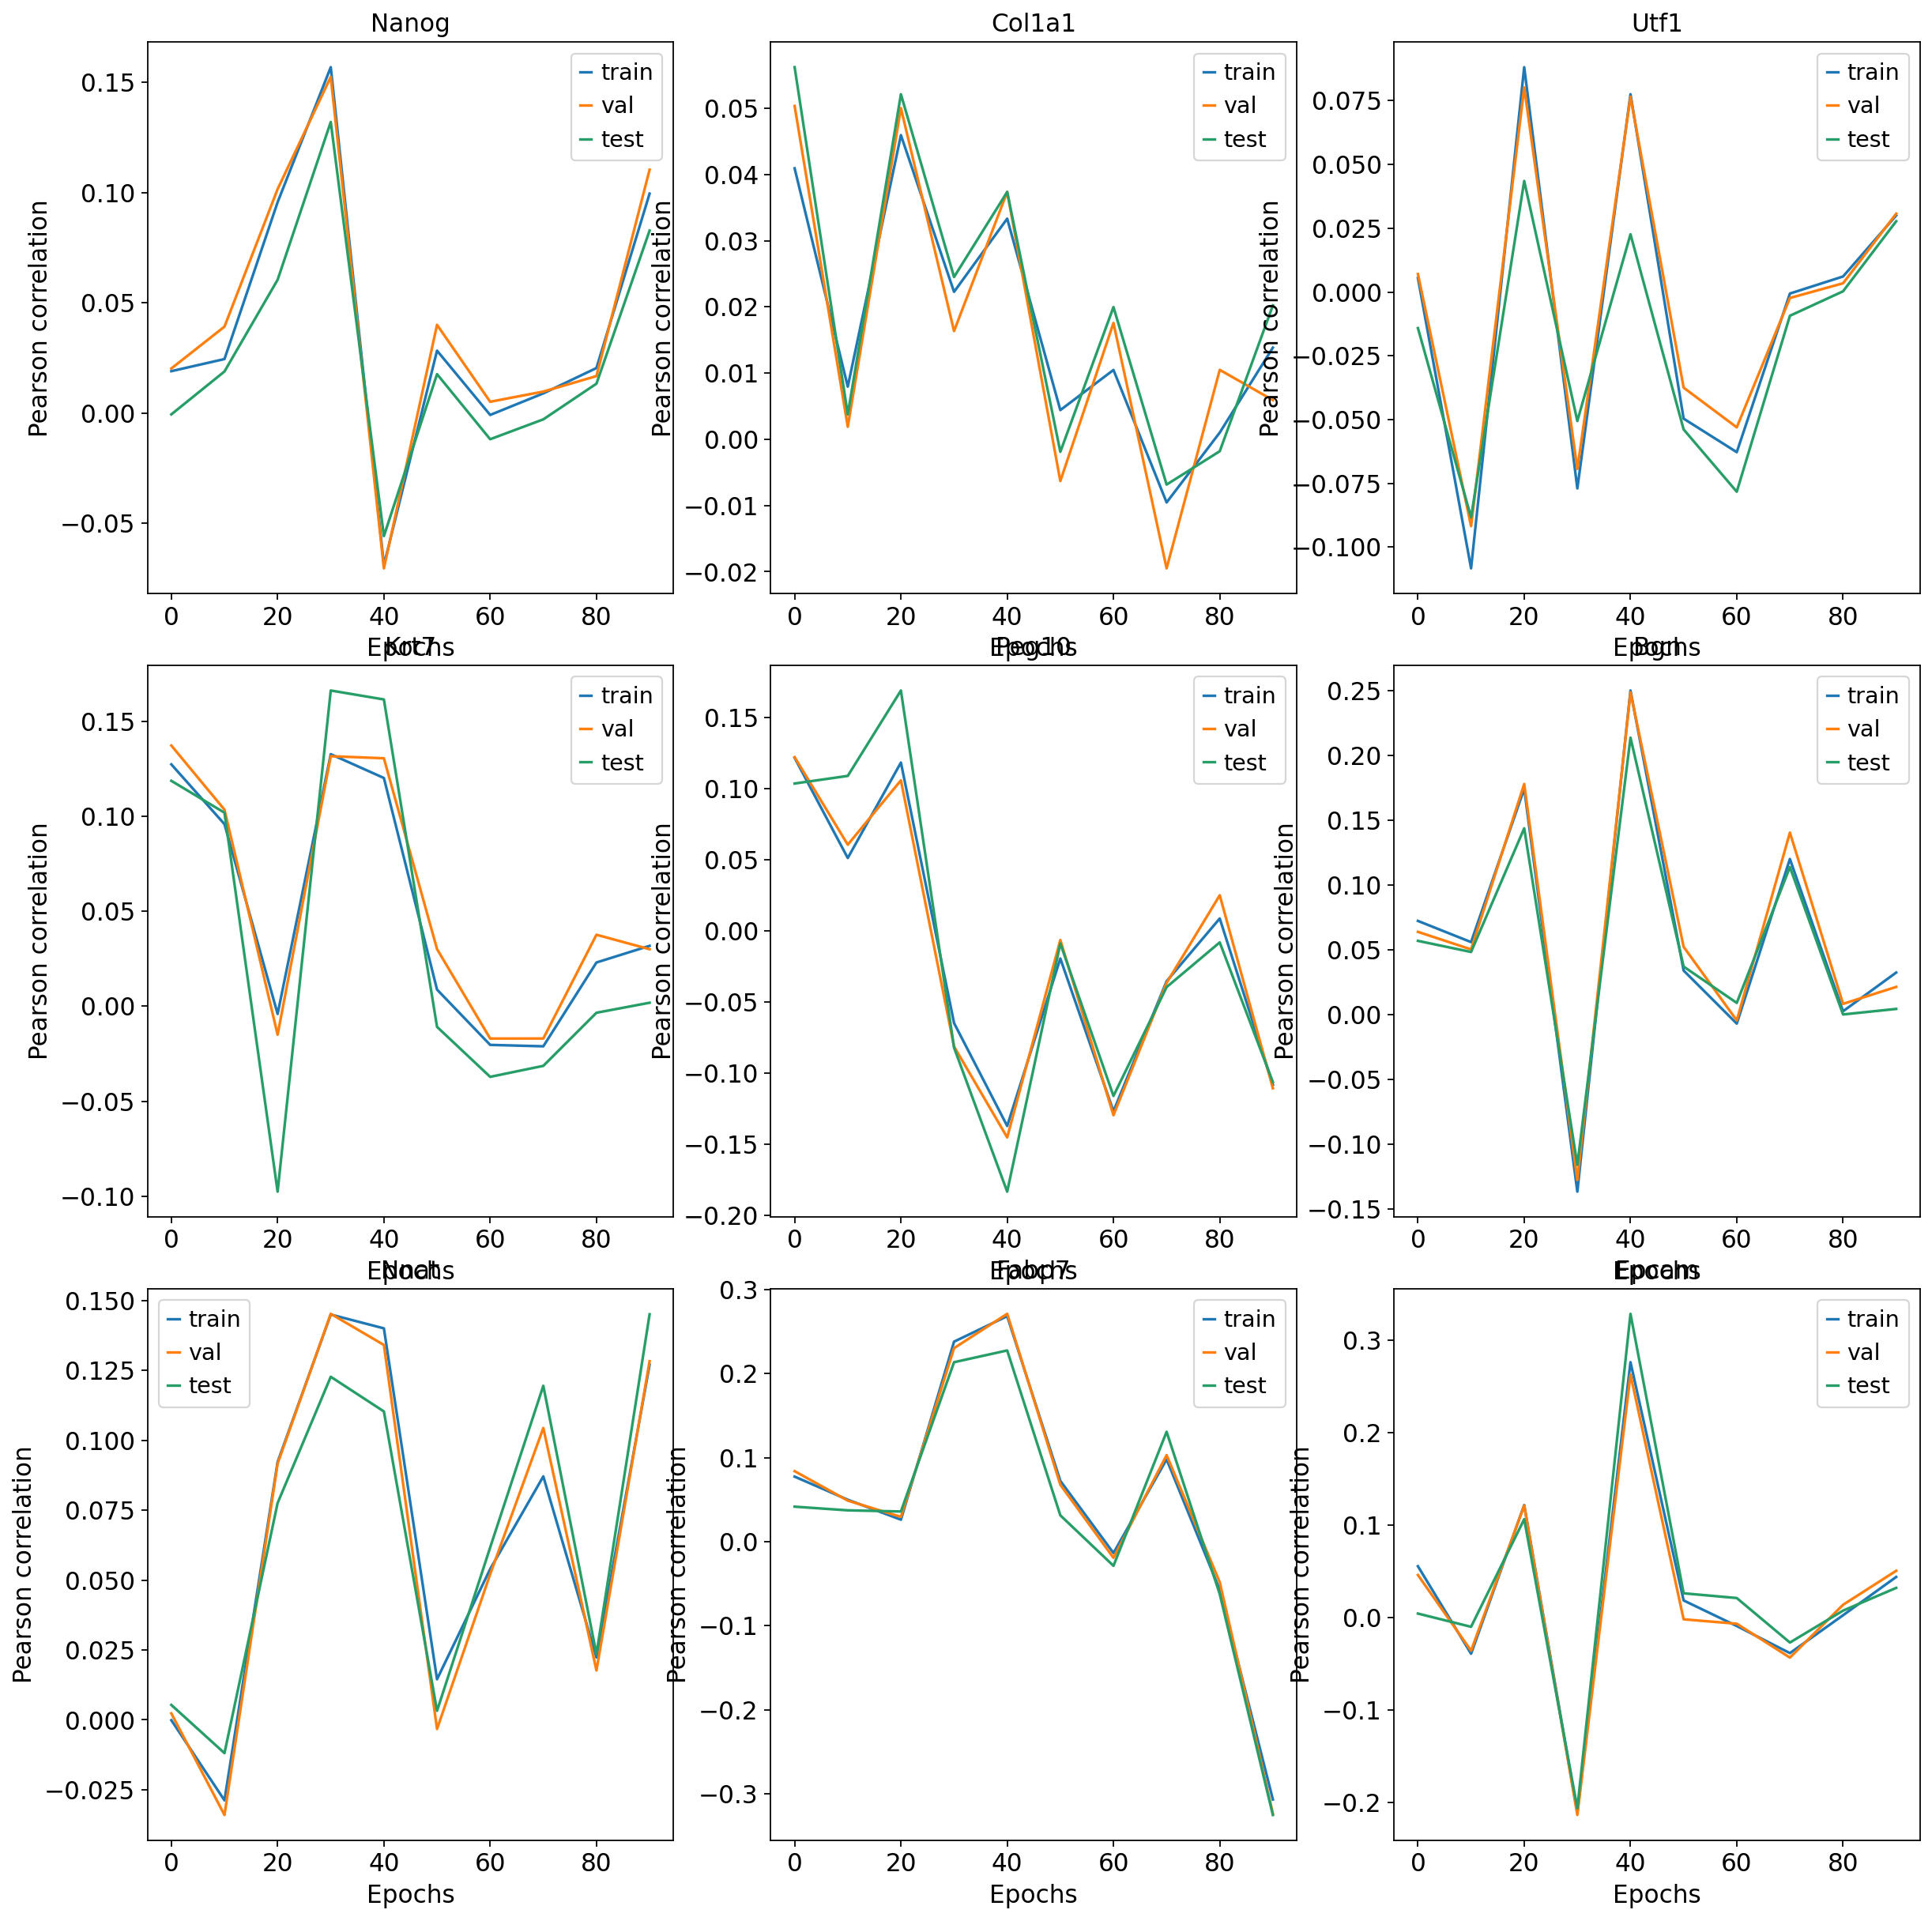

In [56]:
fig,axs = plt.subplots(3,3,figsize=(15,15))
plt.tight_layout()
for g,ax in zip(genes, axs.flat):
    ax.plot(epochs, np.array(corrs[sets[0]][g]))
    ax.plot(epochs, np.array(corrs[sets[1]][g]))
    ax.plot(epochs, np.array(corrs[sets[2]][g]))
    ax.grid(None)
    ax.legend(sets)
    ax.set_title(g)
    ax.set_ylabel('Pearson correlation')
    ax.set_xlabel('Epochs')
fig.savefig('test_train_correlation.pdf')

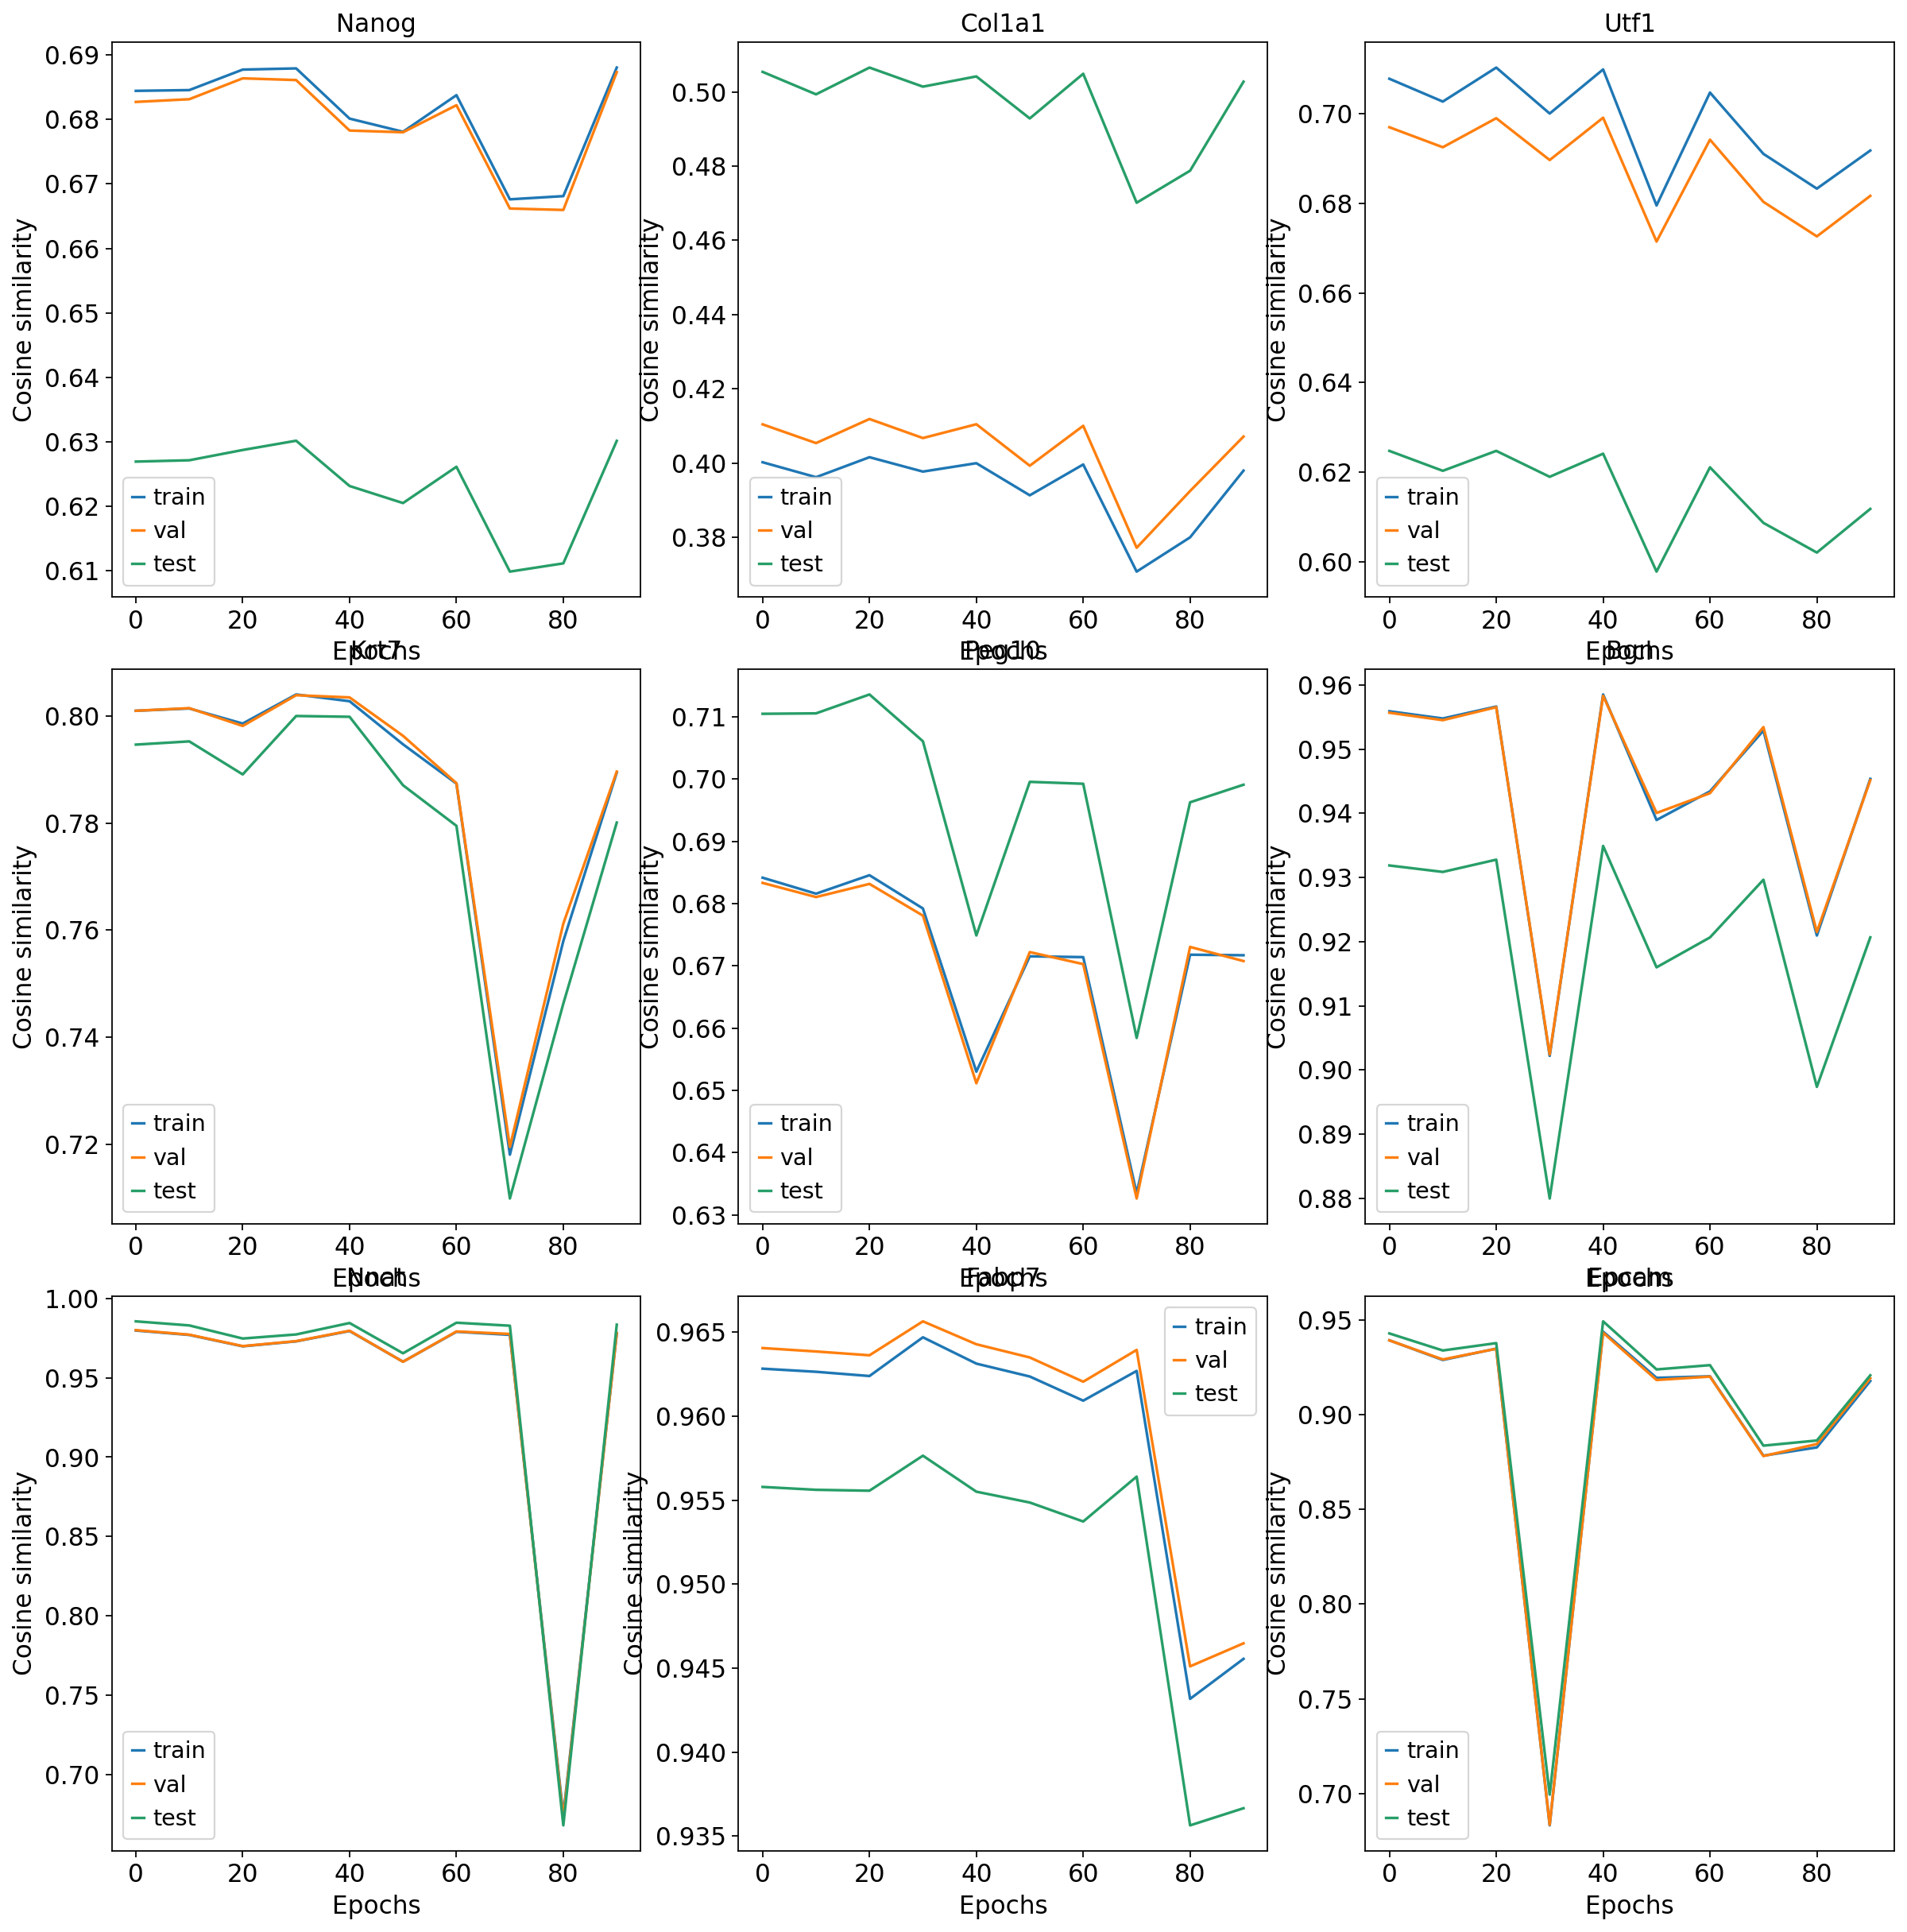

In [57]:
fig,axs = plt.subplots(3,3,figsize=(15,15))
plt.tight_layout()
for g,ax in zip(genes, axs.flat):
    ax.plot(epochs, np.array(cosines[sets[0]][g]))
    ax.plot(epochs, np.array(cosines[sets[1]][g]))
    ax.plot(epochs, np.array(cosines[sets[2]][g]))
    ax.grid(None)
    ax.legend(sets)
    ax.set_title(g)
    ax.set_ylabel('Cosine similarity')
    ax.set_xlabel('Epochs')
fig.savefig('test_train_cosine.pdf')

In [67]:
'''mean correlation per epoch'''
corr_means = {}

for s in sets:
    corr_means[s] = []
    for e in range(len(epochs)):
        tmp = []
        for g in genes:
            tmp.append(corrs[s][g][e])
        corr_means[s].append(np.mean(tmp))

In [68]:
'''mean correlation per epoch'''
cosines_means = {}

for s in sets:
    cosines_means[s] = []
    for e in range(len(epochs)):
        tmp = []
        for g in genes:
            tmp.append(cosines[s][g][e])
        cosines_means[s].append(np.mean(tmp))

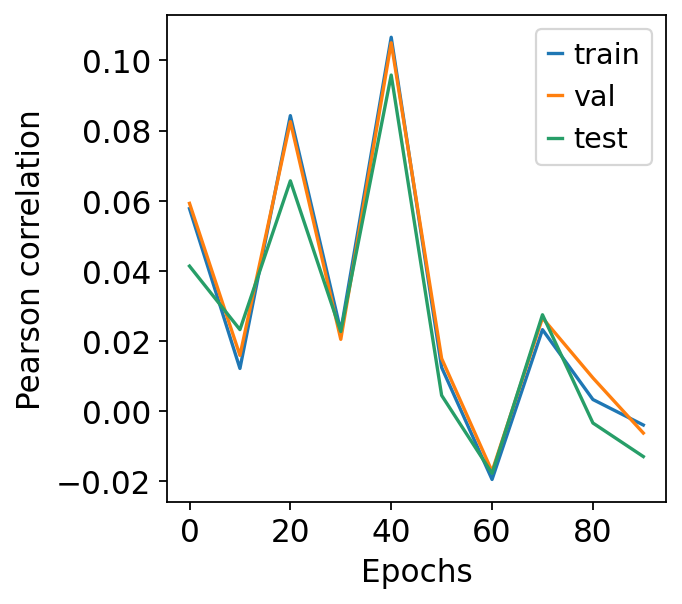

In [72]:
# fig,axs = plt.subplots(3,3,figsize=(15,15))
# plt.tight_layout()
plt.plot(epochs, np.array(corr_means[sets[0]]))
plt.plot(epochs, np.array(corr_means[sets[1]]))
plt.plot(epochs, np.array(corr_means[sets[2]]))
plt.grid(None)
plt.legend(sets)
# plt.title(g)
plt.ylabel('Pearson correlation')
plt.xlabel('Epochs')
fig.savefig('test_train_corr_mean.pdf')


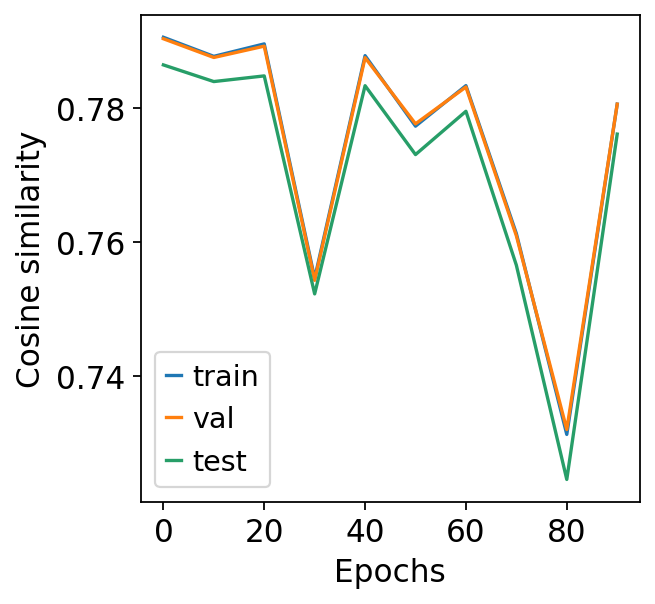

In [70]:
# fig,axs = plt.subplots(3,3,figsize=(15,15))
# plt.tight_layout()
plt.plot(epochs, np.array(cosines_means[sets[0]]))
plt.plot(epochs, np.array(cosines_means[sets[1]]))
plt.plot(epochs, np.array(cosines_means[sets[2]]))
plt.grid(None)
plt.legend(sets)
# plt.title(g)
plt.ylabel('Cosine similarity')
plt.xlabel('Epochs')
fig.savefig('test_train_cosine_mean.pdf')


In [73]:
corr_means

{'train': [0.057728601935240494,
  0.012124781057308801,
  0.08426551468085301,
  0.022801019352906307,
  0.10662639928818045,
  0.012415843933008507,
  -0.01954815277764826,
  0.0232016787438595,
  0.0032622339005895368,
  -0.004017616696793479],
 'val': [0.05923015360340744,
  0.015853002654623752,
  0.0825565747772289,
  0.02042730747799126,
  0.1050623340074217,
  0.014966243796777804,
  -0.01724718362086457,
  0.02652764139978601,
  0.009432323941917207,
  -0.006307916773671103],
 'test': [0.04133012497224792,
  0.023200338325889254,
  0.0656610469811162,
  0.022650260083500143,
  0.0958473096667781,
  0.004443961289786882,
  -0.017812177421314183,
  0.027442818961081174,
  -0.0034419360886668187,
  -0.013017978827504433]}

In [74]:
cosines_means

{'train': [0.79060566,
  0.7877577,
  0.789616,
  0.7546568,
  0.78786445,
  0.7773455,
  0.7833914,
  0.7613237,
  0.7313562,
  0.78063077],
 'val': [0.7903854,
  0.78759086,
  0.7892809,
  0.7543411,
  0.7875612,
  0.77769285,
  0.78318954,
  0.7609972,
  0.7320916,
  0.7806242],
 'test': [0.78648216,
  0.7839968,
  0.7848427,
  0.7523205,
  0.78337884,
  0.7731048,
  0.7795626,
  0.75660163,
  0.7246406,
  0.7761614]}

In [41]:
corrs

{'train': {'Nanog': [0.019038567484329135,
   0.02452853624030156,
   0.09566712492872638,
   0.15690761045262705,
   -0.06894160002351894,
   0.028340397797826208,
   -0.0008197034152583176,
   0.008962112396897197,
   0.02046178742593968,
   0.09956386417641319],
  'Col1a1': [0.04092468700113686,
   0.00794639504486351,
   0.04593733007045017,
   0.022269791811932945,
   0.03332465945366339,
   0.00440705154158948,
   0.010471659321721874,
   -0.00953826169590067,
   0.001012754922787391,
   0.013844440935422581],
  'Utf1': [0.005502497770430521,
   -0.10831290235985154,
   0.08815104830727807,
   -0.07697968243344677,
   0.07755266044188057,
   -0.0496265602038195,
   -0.0627614633935956,
   -0.0005897119374328755,
   0.006099431407327425,
   0.030026569218408898],
  'Krt7': [0.1274882634924004,
   0.09599749921563416,
   -0.004027254674704952,
   0.1328532731330499,
   0.12030495636260209,
   0.00881120229674834,
   -0.02032549902088975,
   -0.021079062618359318,
   0.0230883913492

In [42]:
cosines

{'train': {'Nanog': [0.6844333,
   0.6845497,
   0.6877291,
   0.6879153,
   0.6801264,
   0.67808795,
   0.68376464,
   0.6676072,
   0.66810465,
   0.68804353],
  'Col1a1': [0.40019536,
   0.39617205,
   0.40155458,
   0.39767966,
   0.3999397,
   0.39128923,
   0.39959452,
   0.3707313,
   0.37996185,
   0.39793992],
  'Utf1': [0.7078056,
   0.70271266,
   0.71030533,
   0.70004326,
   0.70989233,
   0.6795235,
   0.70472836,
   0.6910338,
   0.68327487,
   0.691784],
  'Krt7': [0.8010033,
   0.8014337,
   0.7986146,
   0.80405486,
   0.80278915,
   0.79473466,
   0.78738725,
   0.71801275,
   0.75794625,
   0.789448],
  'Peg10': [0.6841543,
   0.6815852,
   0.68455255,
   0.679211,
   0.65300494,
   0.6715283,
   0.6713974,
   0.6334676,
   0.6717858,
   0.6716997],
  'Bgn': [0.95592046,
   0.9547957,
   0.9566542,
   0.9021882,
   0.9585415,
   0.93896484,
   0.94343185,
   0.9529155,
   0.9209536,
   0.9453844],
  'Nnat': [0.9797937,
   0.97700953,
   0.96983856,
   0.9729629,
  